<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/hungarian/ransac/ransac_vonal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANSAC 2D vonal

Ebben a leckében a RANSAC (RANdom SAmple Consensus) módszert mutatjuk be egy egyszerű példán.

RANSAC egy robosztus módszer, például geometriai elemek megtalálására egy pontfelhőben. Egy vonal megtalálásához egy síkbeli ponthalmazon a következő lépéseket hajtjuk végre.

1. válasszunk ki két pontot véletlenszerűen a ponthalmazból
2. írjuk fel a két ponton átmenő egyenes egyenletét
3. keressük meg a vonal közelébe eső pontokat (egy tolerancián belül)
4. ha a közelben lévő pontok száma több mint az eddigi maximum akkor őrizzük meg mint az eddigi legjobb megoldást
5. ismételjük az első lépéstől amíg el nem érjük a megadott ismétlési számot

![A folyamat bemutatása animációval](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/hungarian/ransac/ransac_line_5_48.gif)

Ez az algoritmus nem determinisztikus, azaz, ha többször futtatjuk eltérő eredményeket kaphatunk. Azonban, ha az ismétlési szám elég nagy, akkor közel azonos megoldásokat kapunk.

Az algoritmus két konstans értéktől függ, az egyenestől való maximális távolságtól és az ismétlési számtól.

In [1]:
# Python packages used
import numpy as np                      # for array operations
from matplotlib import pyplot as plt    # for graphic output
from math import sqrt

In [2]:
# parameters
tolerance = 2.5           # max distance from the plane to accept point
rep = 1000                # number of repetition

Az ismétlési szám elég magasra választjuk. Optimális értéke a feldolgozásba bevont pontok számától is függ.

Véletlenszámokat használunk a 2D-s pontok generálásához. *n* pontot generálunk a (0.451 x - y + 2 = 0) egyenes közelében. További *k* pontot generálunk "zajként".

In [3]:
n = 100                     # number of inliers
k = 200                     # number of outliers
rang = 100.0                # range of x, y coordinates
l = [0.451, -1.0, 2.0]      # line equation ax + by + c = 0
x = np.zeros(n+k)
y = np.zeros(n+k)
# points near to the line
x[:n] = np.random.rand(n) * rang
y[:n] = -l[0] / l[1] * x[:n] - l[2] / l[1] + (np.random.rand(n) * 2 * tolerance - tolerance)
# outlier points (noise)
x[n:] = np.random.rand(k) * rang
y[n:] = np.random.rand(k) * rang
points = np.c_[x, y, np.full(n+k, 1.0)] # put together inliers and outliers

Jelenítsük meg a generált pontokat és az egyenest.

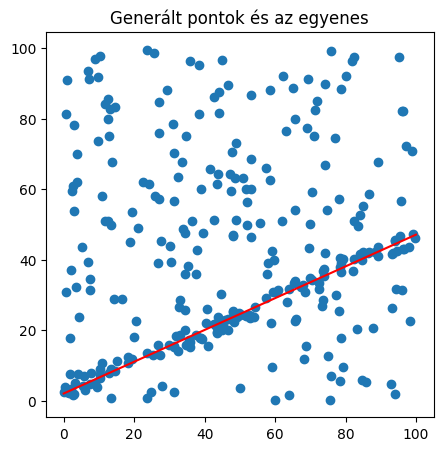

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'r', label='original line')
_ = ax.set_title('Generált pontok és az egyenes')

In [8]:
best_n = 0          # number of points on the best fit line so far
best_i = 0          # iteration index of best fit line so far
best_inliers = np.array([]) # indices of inliers of the best fit line so far
for i in np.arange(rep):
    # select two random points
    p = []  # list of random indices for points
    while len(p) != 2:
        p = list(set(np.random.randint(n+k, size=2))) # remove repeated random integers
    p1 = points[p]  # randomly selected points
    x1 = p1[:,0]    # x coordinates
    y1 = p1[:,1]    # y coordinates
    # line equation from the two points using homogenouos coordinates
    l1 = np.array([y1[0] - y1[1], x1[1] - x1[0], x1[0] * y1[1] - x1[1] * y1[0]])
    l1 = l1 / sqrt(l1[0]**2 + l1[1]**2)     # normalize
    # select close points
    inliers = points[np.abs(np.dot(points, l1)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers.copy()
        best_line = l1.copy()
print(f'Legjobb megoldás {best_i} ismétlés után, pontok száma az egyenesen: {best_n}  egyenes: {best_line}')

Legjobb megoldás 465 ismétlés után, pontok száma az egyenesen: 110  egyenes: [-0.40410867  0.91471098 -2.29434309]


Futtasa többször a fenti kódblokkot és vegye észre az egyes egyenletének változását.

Végül jelenítsük meg a legjobban illeszkedő egyenest.

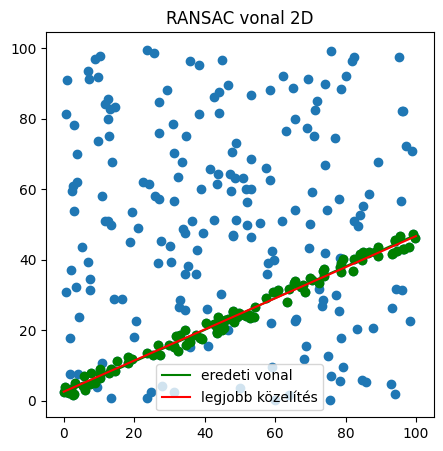

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(x, y)
ax.scatter(best_inliers[:,0], best_inliers[:,1], c='g')
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'g', label='eredeti vonal')
ax.plot([0,100], [-best_line[2] / best_line[1], -best_line[0] / best_line[1] * 100 - best_line[2] / best_line[1]], 'r', label='legjobb közelítés')
ax.legend()
_ = ax.set_title('RANSAC vonal 2D')

#RANSAC 3D egyenes

A 3D-ben történő számítás annyival bonyolódik, hogy a térbeli egyenest paraméteresen tudjuk felírni és a távolság számítás bonyolultabb.

Két adott ponton átmenő 3D egyenes a következő paraméteres felírással adható meg:

$x = x_1 + (x_2 - x_1) \cdot t$

$y = y_1 + (y_2 - y_1) \cdot t$

$z = z_1 + (z_2 - z_1) \cdot t$

Az egyenes távolsága az $(x_0, y_0, z_0)$ ponttól:

$d^2 = (x_1 + (x_2 - x_1) \cdot t -x_0)^2 + (y_1 + (y_2 - y_1) \cdot t - y_0)^2 + (z_1 + (z_2 - z_1) \cdot t - z_0)^2$

A legrövidebb távolságot keressük, ha a távolság négyzet  $t$ szerinti deriváltja nulla.

$t = \frac {(P_0 - P_1) \cdot (P_2 - P_1)} {|P_2 - P_1|^2}$

$P_0 = (x_0, y_0, z_0)$

$t$ értékét az egyenes egyenletébe visszahelyettesítve megkapjuk a tengelyen a legközelebbi pontot, ettől a $P_0$ pont távolsága számítható.

Először készítsük el azt a függvényt mely a legközelebbi, az egyenesen lévő pont koordinátáit kiszámolja.

In [11]:
def point2line(p1, p2, p0):
    """ returns the closest point to p0 on axis p1-p2 """
    t = np.dot(p0 - p1, p2 - p1) / np.sum(np.square(p2 - p1))
    return p1 + (p2 - p1) * t

def dist (p, q):
    """ calculate distance between p-q points """
    return sqrt(np.sum(np.square(p - q)))

Generáljunk véletlen számokkal pontokat.

In [12]:
tolerance = 2.5           # max distance from the line to accept point
t3 = tolerance / sqrt(3)
rep = 1000                # number of repetition

n = 100                   # number of inliers
k = 100                   # number of outliers
rang = 100.0              # range of x, y, z coordinates
x = np.zeros(n+k)
y = np.zeros(n+k)
z = np.zeros(n+k)
p1 = np.array([0, 0, 0])
p2 = np.array([rang, rang, rang])
# points near to the line
t = np.random.rand(n)
x[:n] = p1[0] + (p2[0] - p1[0]) * t + (np.random.rand(n) * 2 * t3 - t3)
y[:n] = p1[1] + (p2[1] - p1[1]) * t + (np.random.rand(n) * 2 * t3 - t3)
z[:n] = p1[2] + (p2[2] - p1[2]) * t + (np.random.rand(n) * 2 * t3 - t3)
# outlier points (noise)
x[n:] = np.random.rand(k) * rang
y[n:] = np.random.rand(k) * rang
z[n:] = np.random.rand(k) * rang
points = np.c_[x, y, z] # put together inliers and outliers

Keressünk térbeli egyenest!

In [13]:
best_n = 0          # number of points on the best fit line so far
best_i = 0          # iteration index of best fit line so far
for i in np.arange(rep):
    # select two random points
    p = []  # list of random indices for points
    while len(p) != 2:
        p = list(set(np.random.randint(n+k, size=2))) # remove repeated random integers
    p1 = points[p[0]]   # randomly selected 1st point
    p2 = points[p[1]]   # randomly selected 2nd point
    # select close points
    inliers = []
    for j in range(points.shape[0]):
        p0 = points[j]
        pt = point2line(p1, p2, p0)
        if dist(pt, p0) < tolerance:
            inliers.append(j)
    if len(inliers) > best_n:
        # better solution found
        best_n = len(inliers)
        best_i = i
        best_inliers = inliers[:]
        #best_line = l1.copy()
print(f'Legjobb megoldás {best_i} ismétlés után, pontok száma az egyenesen: {best_n} ')

Legjobb megoldás 347 ismétlés után, pontok száma az egyenesen: 101 


Ábrázoljuk az eredményt!

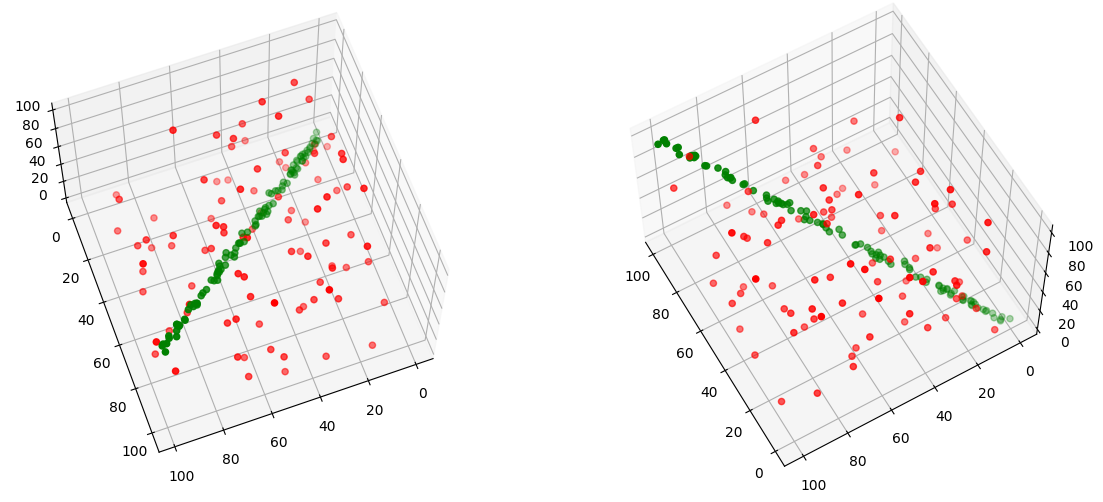

In [14]:
mask = mask = np.ones(points.shape[0], dtype=bool)
mask[best_inliers] = False
outliers = points[mask]
fig = plt.figure(figsize=(14, 6))
ax0 = fig.add_subplot(121, projection='3d')
ax1 = fig.add_subplot(122, projection='3d')
ax0.scatter(outliers[:, 0], outliers[:, 1], outliers[:, 2], label="Zaj", c='red')
ax0.scatter(points[best_inliers, 0], points[best_inliers, 1], points[best_inliers, 2], c='green')
ax1.scatter(points[mask, 0], points[mask, 1], points[mask, 2], label="zaj", c='red')
ax1.scatter(points[best_inliers, 0], points[best_inliers, 1], points[best_inliers, 2], c='green')
ax0.view_init(65, 70)
ax1.view_init(60, 150)